Dataset obtained from https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

EDA logic and code inspired by the following:
* https://www.kaggle.com/code/anerisavani/life-expectancy-eda/notebook
* https://www.kaggle.com/code/premdj/eda-life-expetancy

In [149]:
# imports
import pandas as pd
from pandas import DataFrame
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.graph_objects as go
import plotly.express as px
from plotly.colors import n_colors
import numpy as np
import seaborn as sns
import pandas_profiling
%matplotlib inline
from matplotlib import rc
import scipy.stats
from scipy.stats.mstats import winsorize
import math

In [150]:
# read data
life_expectancy = pd.read_csv('Life Expectancy Data.csv')
life_expectancy.head(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [151]:
# rename columns to be standardized
life_expectancy.rename(columns = {" BMI " :"BMI", 
                                  "Life expectancy ": "Life_expectancy",
                                  "Adult Mortality":"Adult_mortality",
                                  "infant deaths":"Infant_deaths",
                                  "percentage expenditure":"Percentage_expenditure",
                                  "Hepatitis B":"HepatitisB",
                                  "Measles ":"Measles",
                                  "under-five deaths ": "Under_five_deaths",
                                  "Total expenditure":"Total_expenditure",
                                  "Diphtheria ": "Diphtheria",
                                  " thinness  1-19 years":"Thinness_1-19_years",
                                  " thinness 5-9 years":"Thinness_5-9_years",
                                  " HIV/AIDS":"HIV/AIDS",
                                  "Income composition of resources":"Income_composition_of_resources"}, inplace = True)
life_expectancy.columns

Index(['Country', 'Year', 'Status', 'Life_expectancy', 'Adult_mortality',
       'Infant_deaths', 'Alcohol', 'Percentage_expenditure', 'HepatitisB',
       'Measles', 'BMI', 'Under_five_deaths', 'Polio', 'Total_expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'Thinness_1-19_years',
       'Thinness_5-9_years', 'Income_composition_of_resources', 'Schooling'],
      dtype='object')

Num unique in Country: 193


<AxesSubplot:xlabel='Status', ylabel='count'>

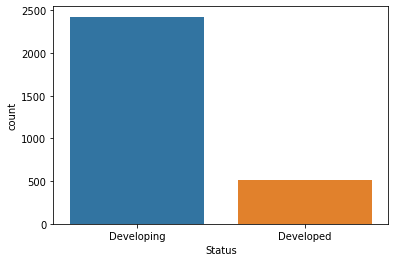

In [152]:
# lets take a look at the categorical features (country, status)
print("Num unique in Country: {}".format(life_expectancy.Country.nunique()))
sns.countplot(x='Status', data=life_expectancy)

Some things of note:
* Lots of unique countries, will it be weird if I use them as categorical variables?
* There are way more developing countries than there are developed ones.
    * We'll want to make sure that the training and testing datasets have a correct proportion of data (i.e. we don't want training set to be all developing and testing set to be all developed)

In [153]:
# lets handle missing values
print(life_expectancy.isnull().sum())


Country                              0
Year                                 0
Status                               0
Life_expectancy                     10
Adult_mortality                     10
Infant_deaths                        0
Alcohol                            194
Percentage_expenditure               0
HepatitisB                         553
Measles                              0
BMI                                 34
Under_five_deaths                    0
Polio                               19
Total_expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
Thinness_1-19_years                 34
Thinness_5-9_years                  34
Income_composition_of_resources    167
Schooling                          163
dtype: int64


Some notes:
* Lots of columns with missing values...
    * None of them have so many missing values that they can be dropped though
* We'll want to fill the missing data somehow
    * Using average probably wouldn't be the best because of potential outliers
    * Using median might work, but we'll need to make it by country basis instead of overall for it to be more accurate
    * The best option will be to interpolate the data using country

In [154]:
life_expectancy.reset_index(inplace=True)
life_expectancy.groupby('Country').apply(lambda group: group.interpolate(method= 'linear'))

print(life_expectancy.isnull().sum())

index                                0
Country                              0
Year                                 0
Status                               0
Life_expectancy                     10
Adult_mortality                     10
Infant_deaths                        0
Alcohol                            194
Percentage_expenditure               0
HepatitisB                         553
Measles                              0
BMI                                 34
Under_five_deaths                    0
Polio                               19
Total_expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
Thinness_1-19_years                 34
Thinness_5-9_years                  34
Income_composition_of_resources    167
Schooling                          163
dtype: int64


Some notes:
* Unfortunately there are still lots of missing values.
    * This is likely because some countries had null data for each year, and many of the null values are in the first entry, which isn't touched by linear interpolation by country.
* Lets go with our second best option: using median by country.

In [155]:
imputed_data = []
for year in list(life_expectancy.Year.unique()):
    year_data = life_expectancy[life_expectancy.Year == year].copy()
    for col in list(year_data.columns)[4:]:
        year_data[col] = year_data[col].fillna(year_data[col].dropna().median()).copy()
    imputed_data.append(year_data)
life_expectancy = pd.concat(imputed_data).copy()

print(life_expectancy.isnull().sum())

index                              0
Country                            0
Year                               0
Status                             0
Life_expectancy                    0
Adult_mortality                    0
Infant_deaths                      0
Alcohol                            0
Percentage_expenditure             0
HepatitisB                         0
Measles                            0
BMI                                0
Under_five_deaths                  0
Polio                              0
Total_expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
Thinness_1-19_years                0
Thinness_5-9_years                 0
Income_composition_of_resources    0
Schooling                          0
dtype: int64


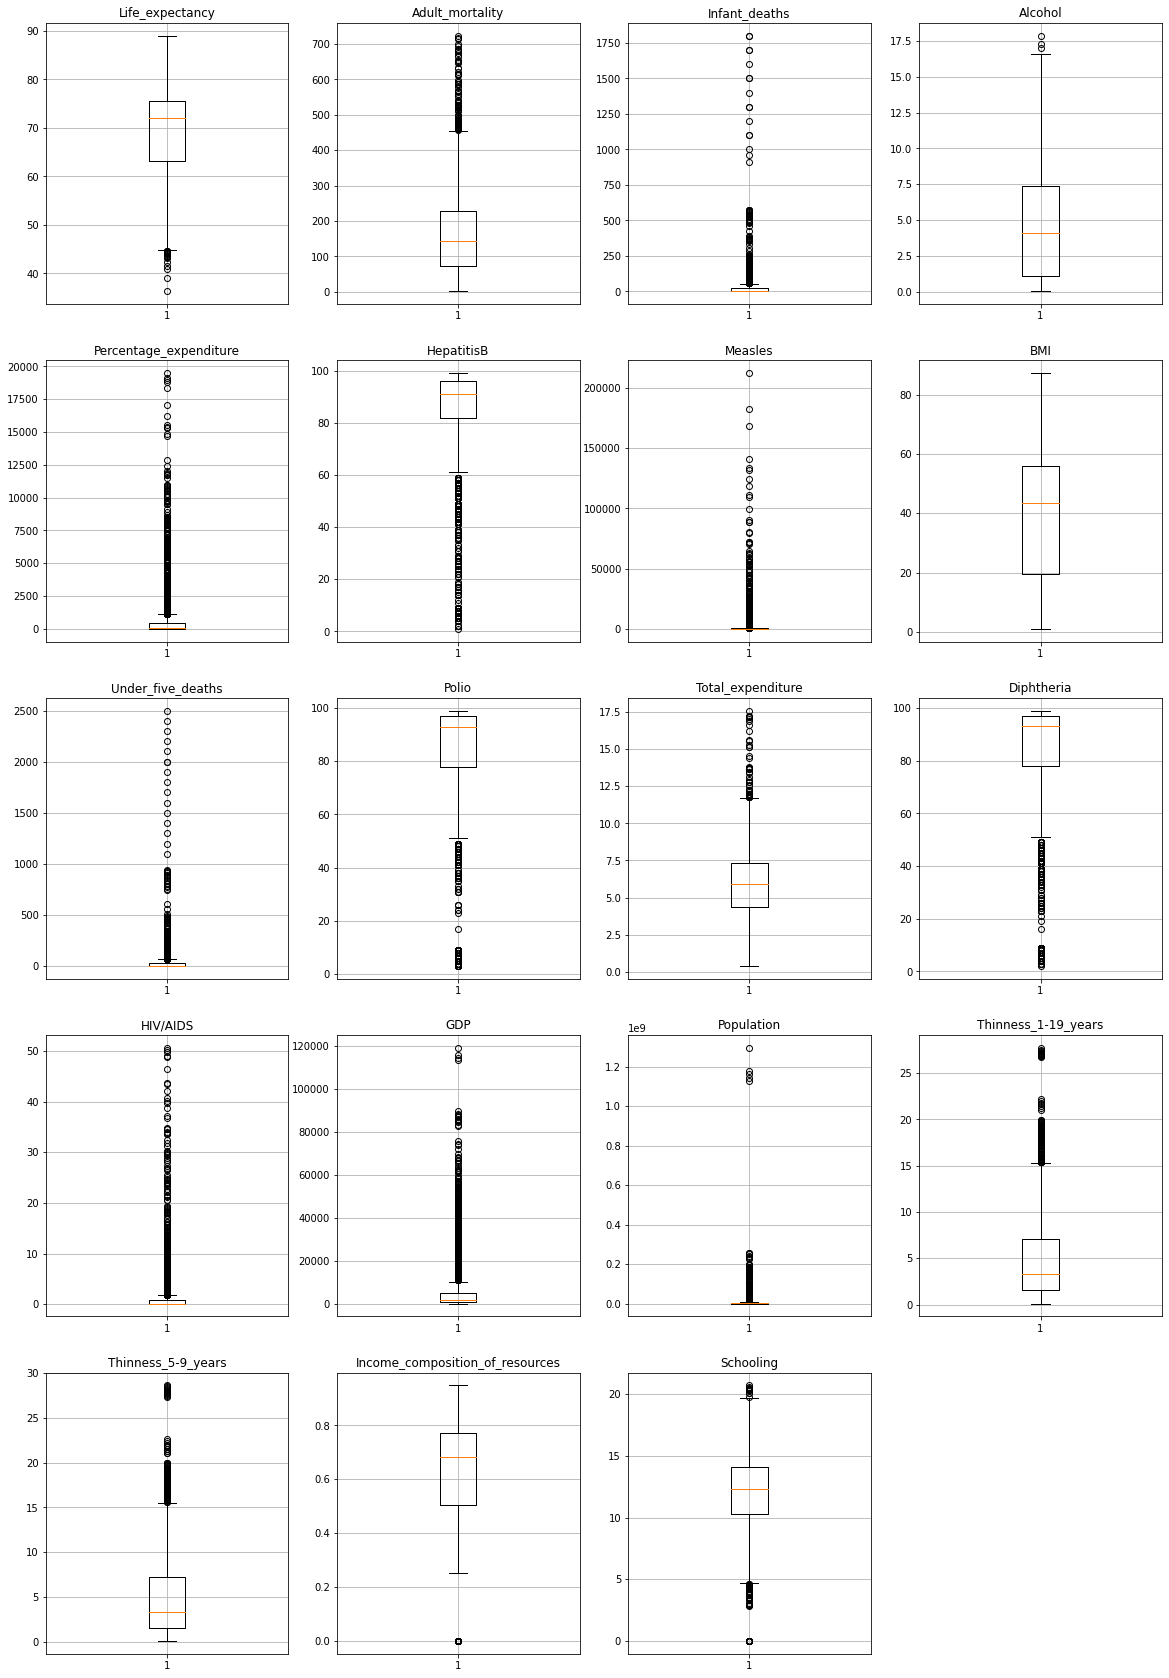

In [156]:
# lets see if there are any outliers
def check_outliers(dict, df):

    # Detect outliers in each variable using box plots.
    fig = plt.figure(figsize=(20,30))

    for variable,i in col_dict.items():
                        plt.subplot(5,4,i)
                        plt.boxplot(life_expectancy[variable])
                        plt.title(variable)
                        plt.grid(True)
        
    plt.show()

col_dict = {'Life_expectancy':1,'Adult_mortality':2,'Infant_deaths':3,'Alcohol':4,'Percentage_expenditure':5,'HepatitisB':6,'Measles':7,'BMI':8,'Under_five_deaths':9,'Polio':10,'Total_expenditure':11,'Diphtheria':12,'HIV/AIDS':13,'GDP':14,'Population':15,'Thinness_1-19_years':16,'Thinness_5-9_years':17,'Income_composition_of_resources':18,'Schooling':19}
check_outliers(col_dict, life_expectancy)

Some notes:
* Many of the outliers for infant deaths don't make sense. They're over 1000 and thus are over what the category is being measured over. These rows will be removed.
    * The same applies for measles and under five deaths.
* GDP has a lot of outliers. The vast majority of countries are spending under 2500% of their GDP on health. Since a lot of the values here are large we'll probably want to take a log value.
    * The same applies for percentage expenditure.
* Population has some really small values... Let's go through and check each row per country.
    * If a row for a country is < than the max value of population for country, replace it with the max
* BMI is really bad. A BMI of 40 is considered as extreme obesity, but in the data the median bove 40. We'll just drop this column.
* We'll just use windsorization for the other columns' outliers.

In [157]:
# removing rows where infant deaths, measles, and under five deaths are > 1000
life_expectancy = life_expectancy[life_expectancy['Infant_deaths'] < 1001]
life_expectancy = life_expectancy[life_expectancy['Measles'] < 1001]
life_expectancy = life_expectancy[life_expectancy['Under_five_deaths'] < 1001]

In [158]:
# removing BMI column
life_expectancy.drop(['BMI'], axis=1, inplace=True)

In [159]:
# taking a log value of GDP, percentage expenditure, and population
life_expectancy['Percentage_expenditure'] = np.log(life_expectancy['Percentage_expenditure'])
life_expectancy['GDP'] = np.log(life_expectancy['GDP'])

/Users/coolb/Documents/DS503/final_project/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [160]:
# replace population
def order_of_mag(num):
    return np.floor(np.log(num))

country_list = life_expectancy['Country'].unique()
for country in country_list:
    df_country = life_expectancy.loc[life_expectancy['Country'] == country]
    country_max_pop = df_country['Population'].max()
    life_expectancy.loc[(life_expectancy['Country'] == country) & 
    (order_of_mag(life_expectancy['Population']) < order_of_mag(country_max_pop)),
     'Population'] = country_max_pop

In [161]:
# replacing infinity values because of the above runtime warning
life_expectancy = life_expectancy.replace([np.inf, -np.inf], 0)

In [162]:
# winsorizing the other columns
life_expectancy['Life_expectancy'] = winsorize(life_expectancy['Life_expectancy'], (0.05,0))
life_expectancy['Adult_mortality'] = winsorize(life_expectancy['Adult_mortality'], (0,0.04))
life_expectancy['Alcohol'] = winsorize(life_expectancy['Alcohol'], (0.0,0.01))
life_expectancy['HepatitisB'] = winsorize(life_expectancy['HepatitisB'], (0.20,0.0))
life_expectancy['Polio'] = winsorize(life_expectancy['Polio'], (0.20,0.0))
life_expectancy['Total_expenditure'] = winsorize(life_expectancy['Total_expenditure'], (0.0,0.02))
life_expectancy['Diphtheria'] = winsorize(life_expectancy['Diphtheria'], (0.11,0.0))
life_expectancy['HIV/AIDS'] = winsorize(life_expectancy['HIV/AIDS'], (0.0,0.21))
life_expectancy['Thinness_1-19_years'] = winsorize(life_expectancy['Thinness_1-19_years'], (0.0,0.04))
life_expectancy['Thinness_5-9_years'] = winsorize(life_expectancy['Thinness_5-9_years'], (0.0,0.04))
life_expectancy['Income_composition_of_resources'] = winsorize(life_expectancy['Income_composition_of_resources'], (0.05,0.0))
life_expectancy['Schooling'] = winsorize(life_expectancy['Schooling'], (0.03,0.01))

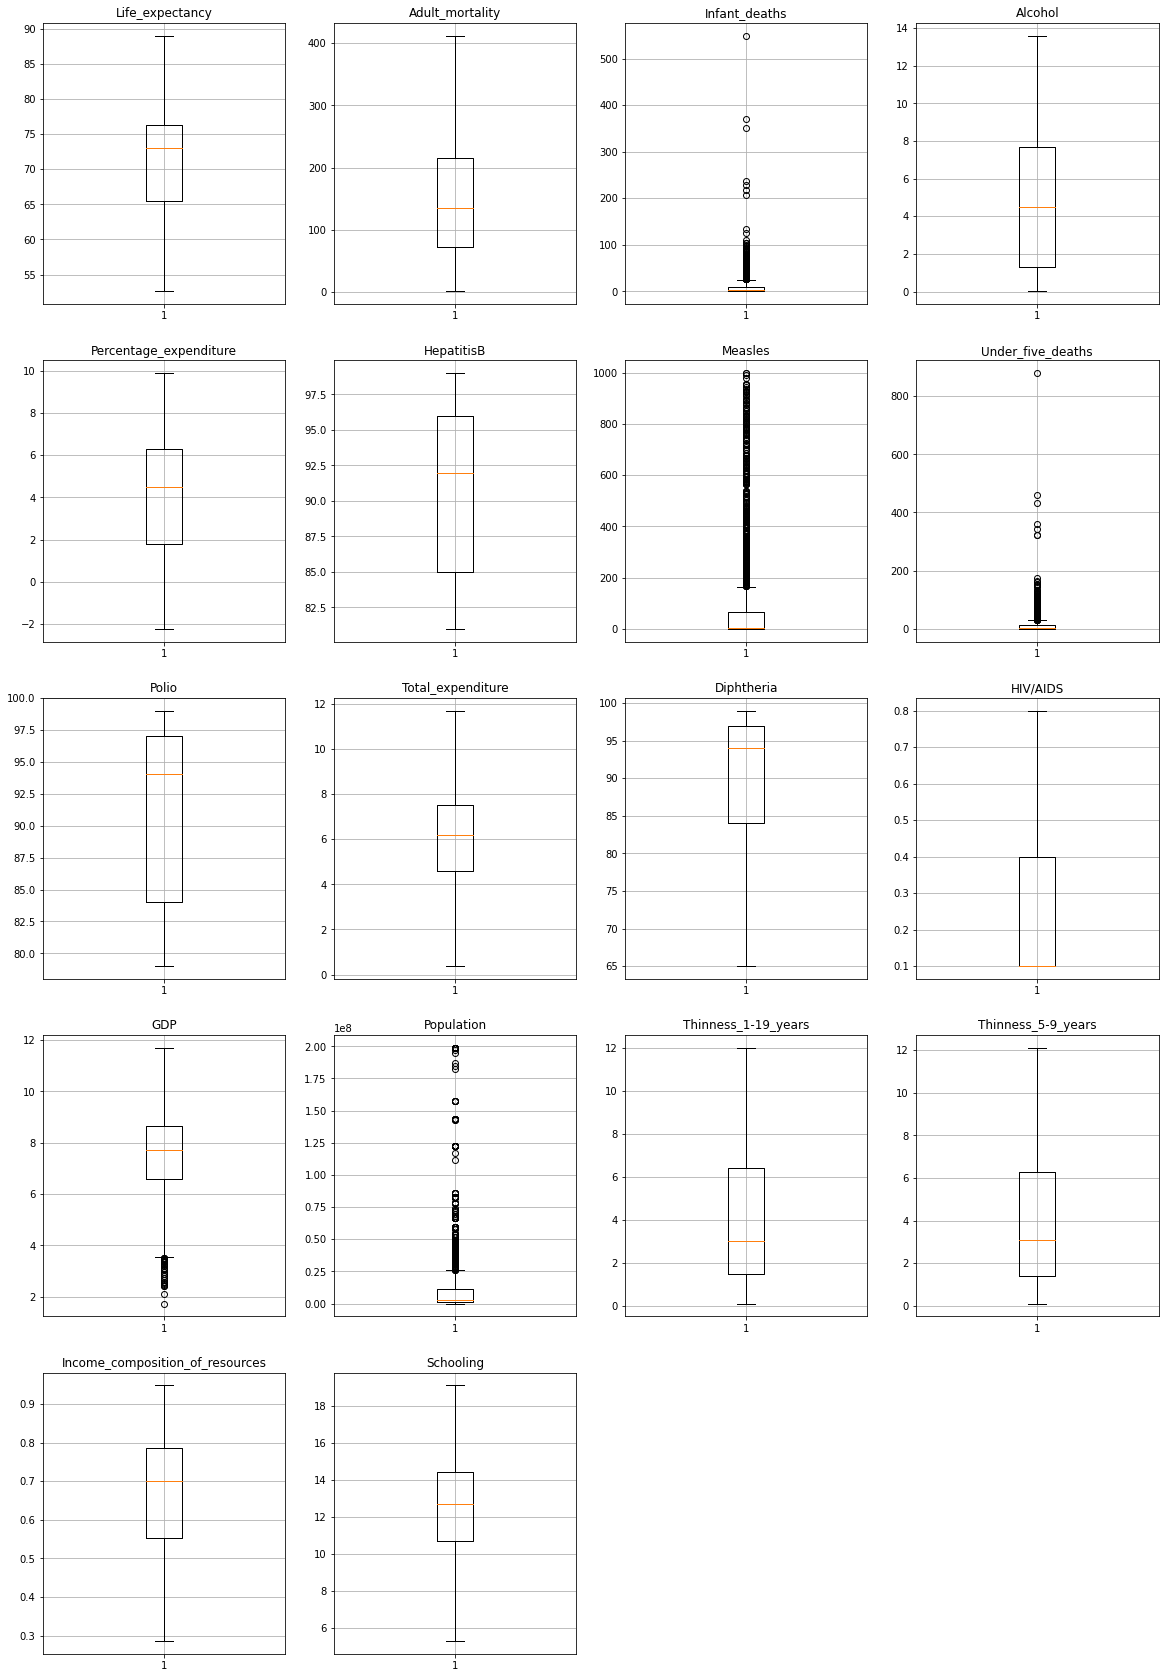

In [163]:
# after all this processing, lets check again for outliers
col_dict = {'Life_expectancy':1,'Adult_mortality':2,'Infant_deaths':3,'Alcohol':4,'Percentage_expenditure':5,'HepatitisB':6,'Measles':7,'Under_five_deaths':8,'Polio':9,'Total_expenditure':10,'Diphtheria':11,'HIV/AIDS':12,'GDP':13,'Population':14,'Thinness_1-19_years':15,'Thinness_5-9_years':16,'Income_composition_of_resources':17,'Schooling':18}
check_outliers(col_dict, life_expectancy)

Some notes:
* Even after taking the log value, the column for measles still has some pretty outrageous values. We'll drop this column.
* Otherwise things look reasonable

In [164]:
# drop measles
life_expectancy.drop('Measles', axis=1, inplace=True)

In [165]:
# lets look at some stats for good measure
print("life expectancy shape: {}".format(life_expectancy.shape))
print("life expectancy unique statuses: {}".format(life_expectancy.Status.unique()))
print("life_expectancy unique countries: {}".format(life_expectancy.Country.nunique()))
print("\ncountry status stuff:")
print(life_expectancy.groupby('Status').Country.nunique())
print("life_expectancy years: {}".format(life_expectancy.Year.unique()))

life expectancy shape: (2413, 21)
life expectancy unique statuses: ['Developing' 'Developed']
life_expectancy unique countries: 190

country status stuff:
Status
Developed      32
Developing    158
Name: Country, dtype: int64
life_expectancy years: [2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 2002
 2001 2000]


In [166]:
# lets define the categorical features and numerical features now
cat_features = [feature for feature in life_expectancy.columns if life_expectancy[feature].dtypes=='O']
print("categorical features: {}".format(cat_features))

num_features = list(life_expectancy.drop(cat_features, axis=1).drop('index', axis=1).columns)
print("numerical features: {}".format(num_features))

categorical features: ['Country', 'Status']
numerical features: ['Year', 'Life_expectancy', 'Adult_mortality', 'Infant_deaths', 'Alcohol', 'Percentage_expenditure', 'HepatitisB', 'Under_five_deaths', 'Polio', 'Total_expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'Thinness_1-19_years', 'Thinness_5-9_years', 'Income_composition_of_resources', 'Schooling']


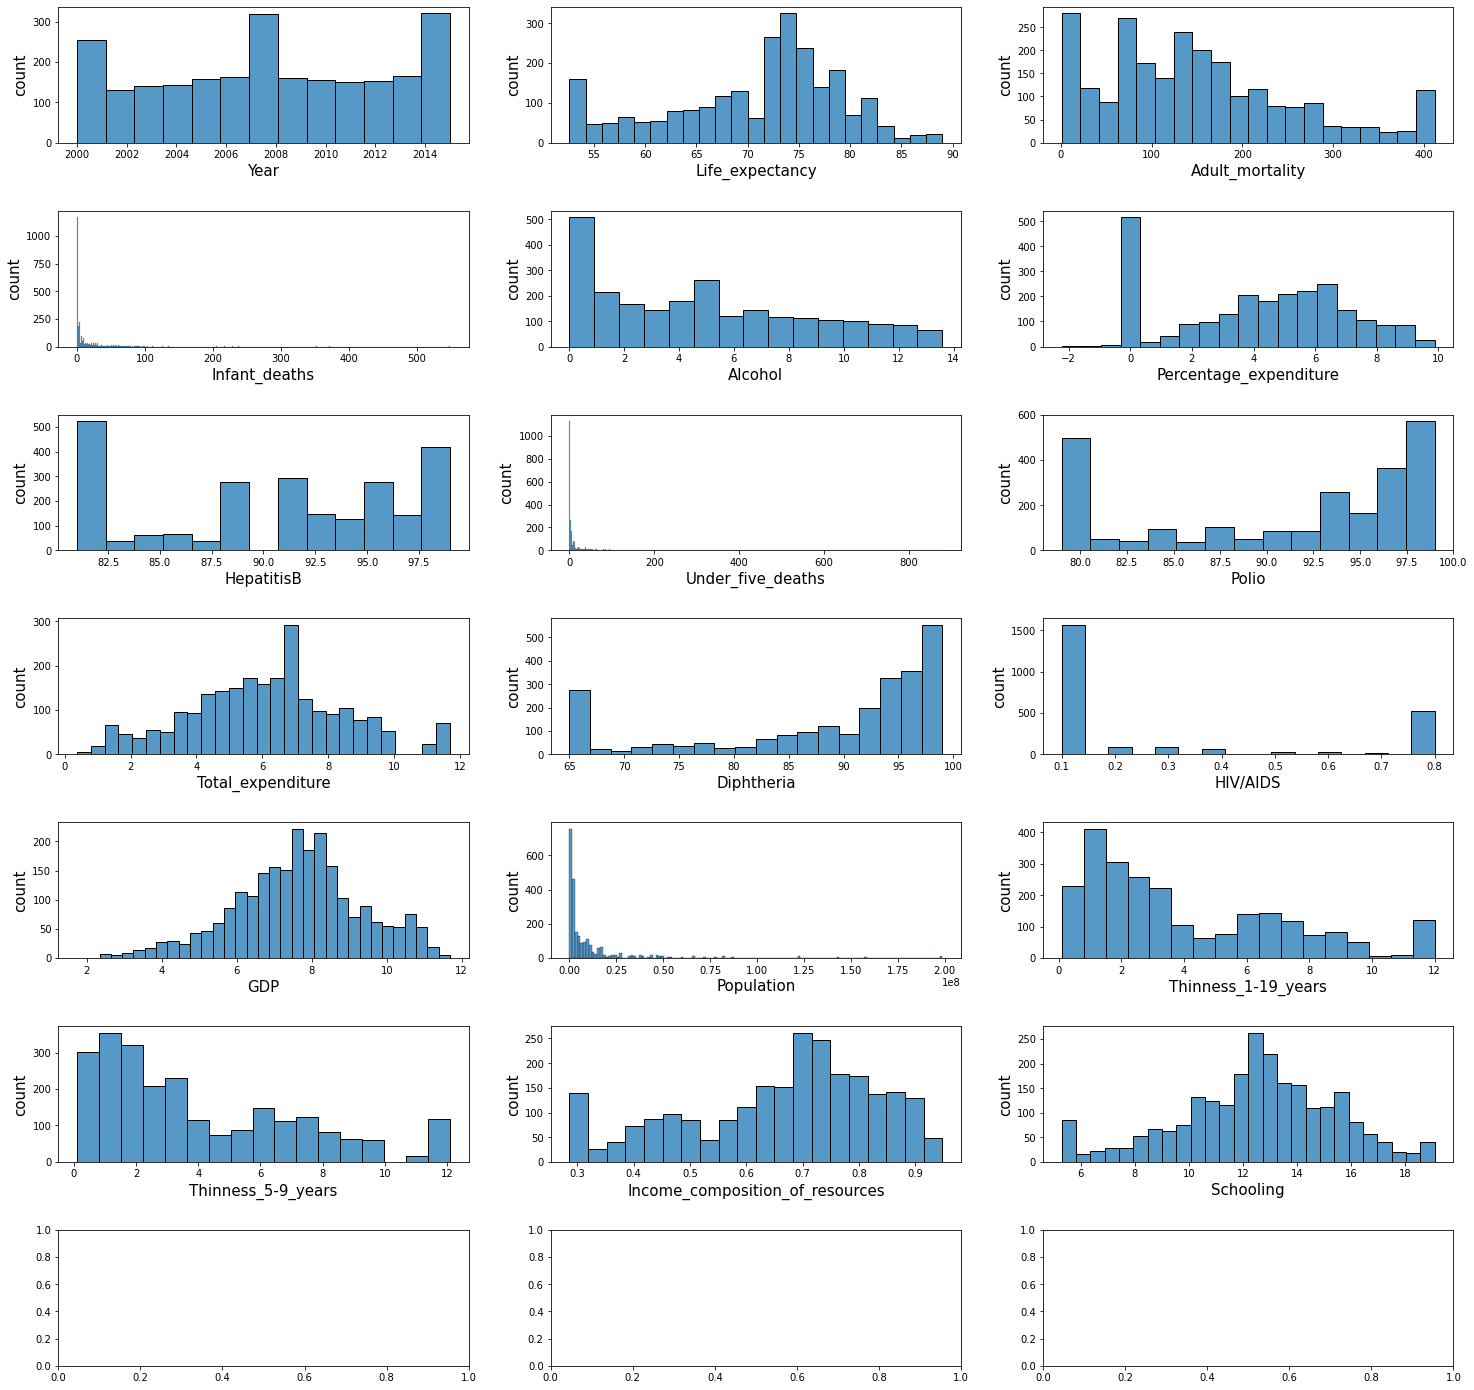

In [167]:
# lets analyzie numeric features
fig, axs = plt.subplots(7,3, figsize=(25,25))
plt.subplots_adjust(hspace=0.5)
for c, feature in enumerate(num_features):
    a= sns.histplot(x=feature, data=life_expectancy, ax=axs.flat[c],)
    a.set_xlabel(feature,fontsize=15)
    a.set_ylabel('count',fontsize=15)

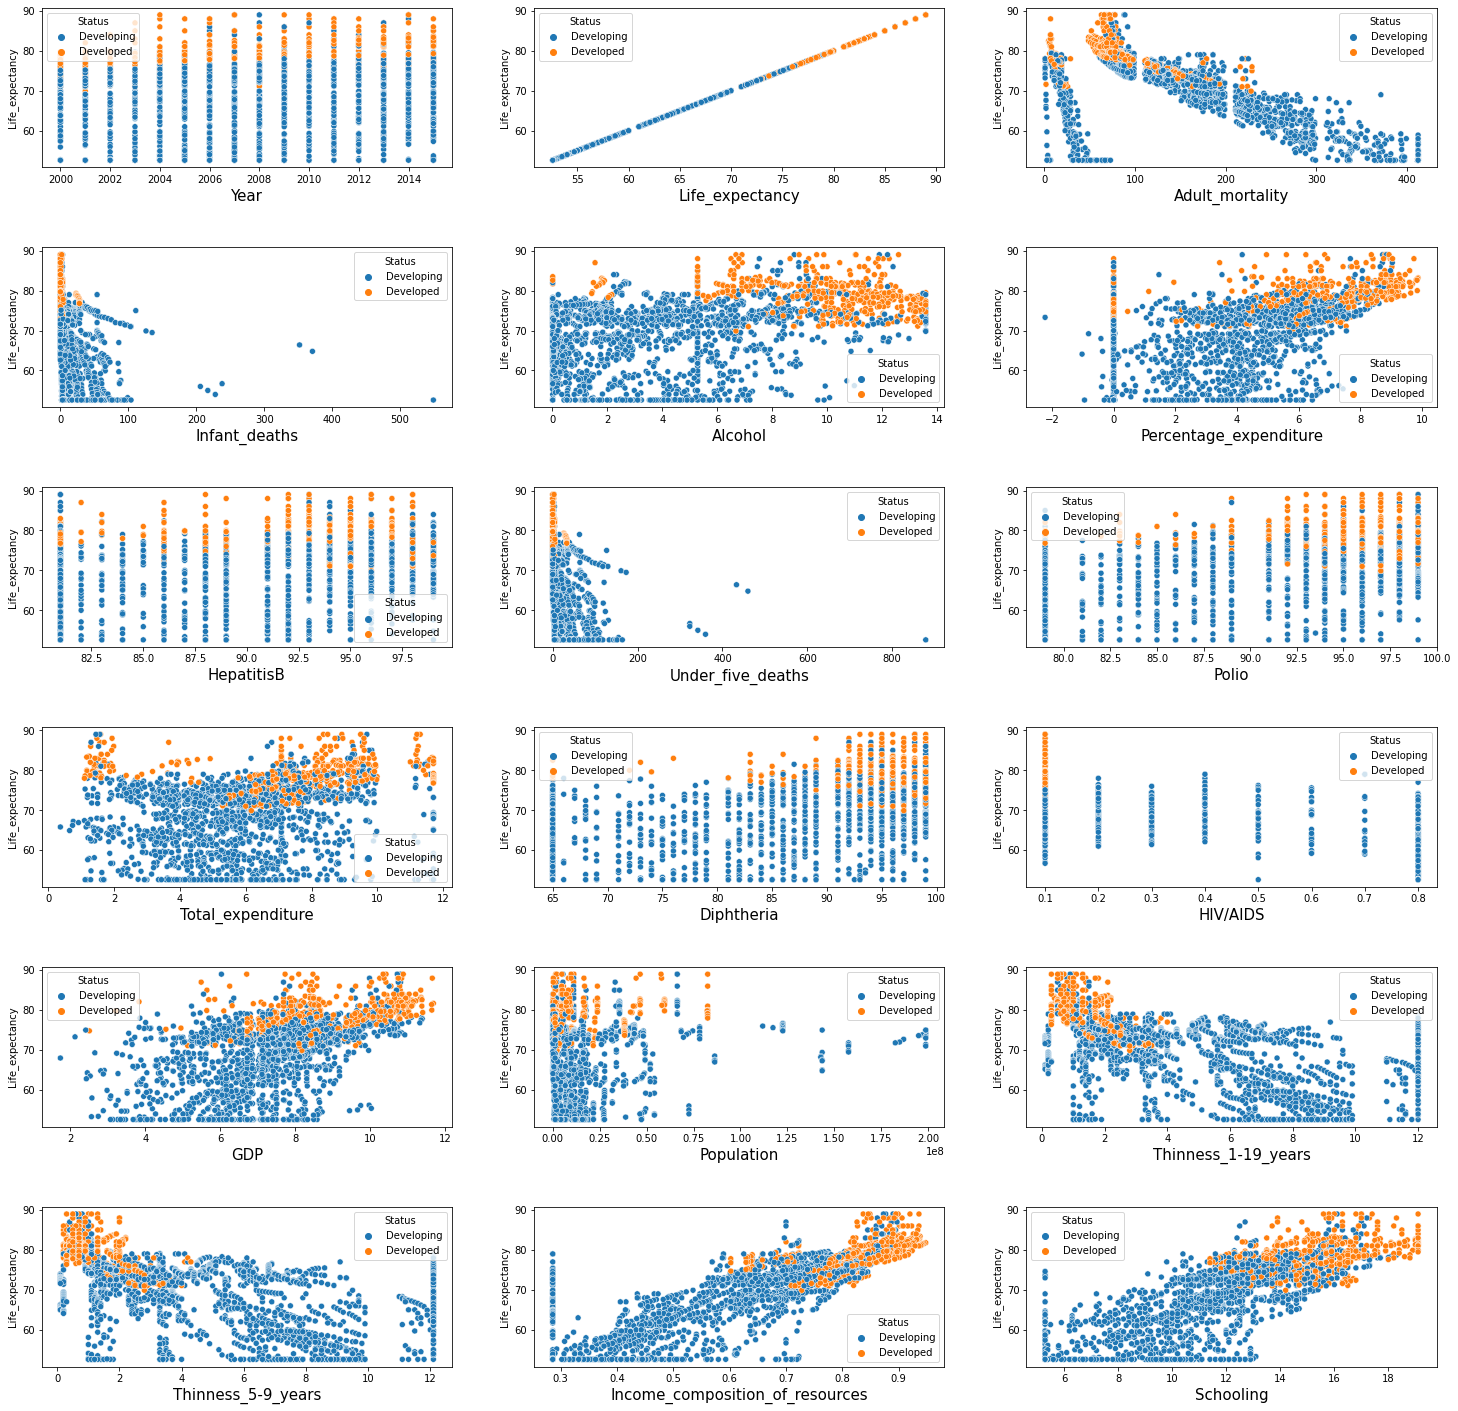

In [168]:
# lets compare the numerical features against life expectancy!
fig, axs = plt.subplots(6,3, figsize=(25,25))
plt.subplots_adjust(hspace=0.5)
for c, feature in enumerate(num_features):
    a = sns.scatterplot(x=feature, y='Life_expectancy', data=life_expectancy, ax = axs.flat[c], hue='Status')
    a.set_xlabel(feature,fontsize=15)

Some notes:
* Developed country's have higher life expectancy (LE)
* There isn't really much change in LE per year
* When adult mortality is under 100, there isn't much correlation, but otherwise there is a negative correlation between adult mortality and LE
* There doesn't seem to be as much correlation with LE for infant deaths in developed countries
    * Otherwise it looks like there's a somewhat negative correlation between the two in developing countries
    * This also applies to under five deaths
* Alcohol doesn't seem to have much correlation with LE, more so for developed countries than developing countries
* No strong correlation between LE and HepB visible here
* Polio, HepB, and Diptheria don't seem to have a strong correlation with LE?
* Somewhat negative correlation for HIV/AIDS with LE
* Positive correlation between GDP and LE
* No visible correlation between population and LE
* Negative correlation between LE and both thinness metrics
* Positive correlation for schooling and income composition of resources and LE

In [174]:
# remove index because we forgot about it lol
life_expectancy.drop('index', axis=1, inplace=True)

correlation figures:
Life_expectancy                    1.000000
Income_composition_of_resources    0.794454
Schooling                          0.756640
GDP                                0.560605
Polio                              0.525098
Diphtheria                         0.520321
Alcohol                            0.415277
Percentage_expenditure             0.378216
HepatitisB                         0.294155
Total_expenditure                  0.219084
Year                               0.097925
Population                         0.039003
Infant_deaths                     -0.396821
Under_five_deaths                 -0.427420
Thinness_1-19_years               -0.577923
Thinness_5-9_years                -0.584153
Adult_mortality                   -0.705565
HIV/AIDS                          -0.775039
Name: Life_expectancy, dtype: float64


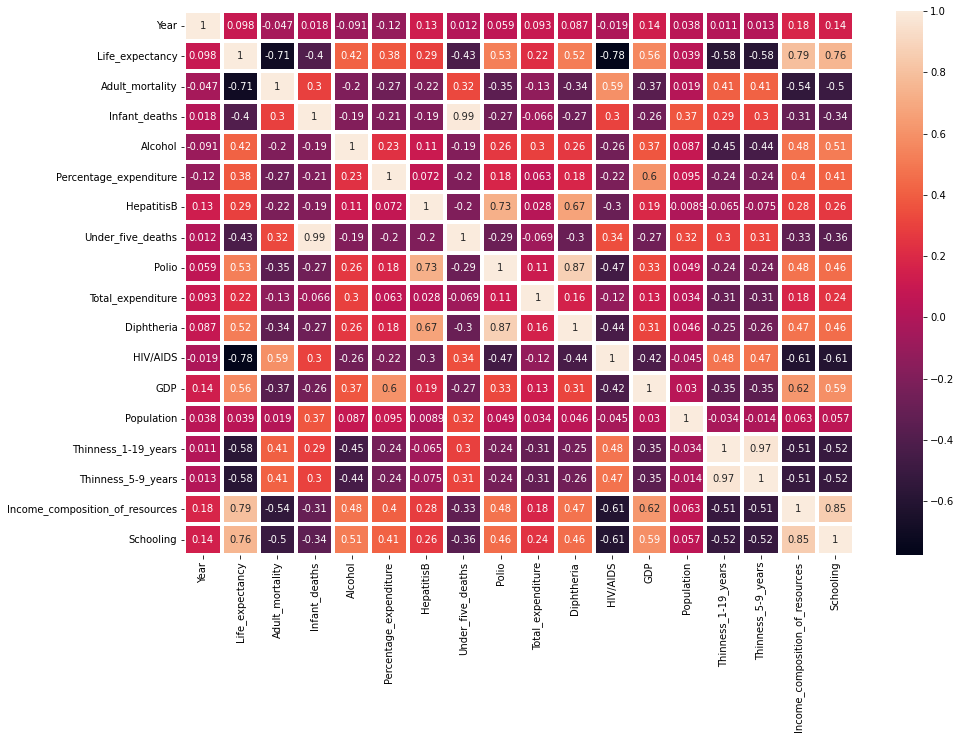

In [175]:
# lets see if our general thoughts are correct
print("correlation figures:\n{}".format(life_expectancy.corr()['Life_expectancy'].sort_values(ascending=False)))
plt.figure(figsize=(15,10))
a =sns.heatmap(life_expectancy.corr(),annot=True,linewidths=4)

Some notes:
* Features with positive correlation (>0.5) with LE
    * Polio, Diptheria, GDP, income composition of resources, schooling
* Features with negative correlation (<-0.5) with LE
    * Adult mortality, HIV/AIDS, thinness 1-19 years, thinnes 5-9 years

Lets see if these are reflected in the ML part of the project